# Import

In [ ]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 27.9 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import os
from PIL import Image
import pickle
import pytorch_lightning as pl

# Task: Human face to anime

### Approaches:
* AE that contains only CNN layers
* AE that contains dense layers after and before CNNs.
* same as above but implement VAE

#### Advanced ideas
* U net architicture - https://www.geeksforgeeks.org/u-net-architecture-explained/
* feature extractor from timm

## Download Human face Data

In [ ]:
import kagglehub

# # Download latest version
path = kagglehub.dataset_download("ashwingupta3012/human-faces")
data_path = '/kaggle/input/human-faces/Humans'
print("Path to dataset files:", path)

!mv /root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1 ./

100%|██████████| 1.82G/1.82G [00:22<00:00, 87.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1


In [ ]:
data_path = '/kaggle/input/human-faces/Humans'
data_path = '/content/1/Humans'

## testing models shapes


torch.Size([4, 1200, 1143])


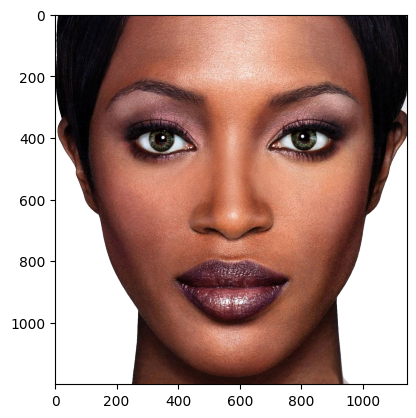

torch.Size([1, 3, 512, 512])
torch.Size([1, 128, 512, 512])
torch.Size([1, 3, 512, 512])


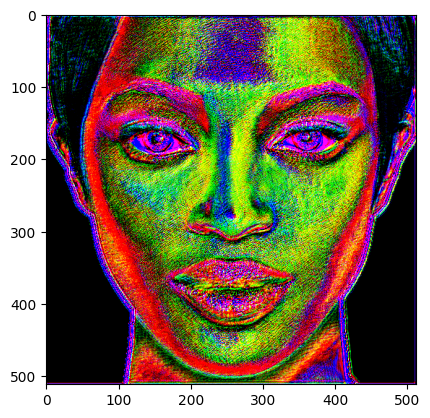

In [ ]:
# im_path = "/kaggle/input/human-faces/Humans/1 (96).png"
# im_path = '/kaggle/input/human-faces/Humans/1 (1684).jpg'

# image = Image.open(im_path)
# print(transforms.ToTensor()(image).shape)
# plt.imshow(image)
# plt.show()

# transform = transforms.Compose([
#     transforms.Resize((512,512)),
#     transforms.ToTensor()
# ])

# image = transform(image)
# if image.shape[0] == 4:
#     image = image[:-1,:,:]
# image = image.unsqueeze(0)
# # print(image.unsqueeze(0).shape)

# convs = [3, 32, 64, 128]
# m_convVEncoder = convEncoder(convs)
# m_convVDecoder = convDecoder(convs)

# # Print the model architecture
# enc = m_convVEncoder(image)
# dec = m_convVDecoder(enc)

# print(image.shape)
# print(enc.shape)
# print(dec.shape)
# #.transpose(1, 2, 0)
# plt.imshow(dec.detach().squeeze().numpy().transpose(1, 2, 0))
# # plt.imshow(dec.detach().squeeze().numpy())
# plt.show()


## Get valid images paths

### Load pickle file faster, (if exist)

In [ ]:
# load from pickle
# human_images_paths = pickle.load(open('human_images_paths.pkl', 'rb'))
data_path = '/kaggle/input/human-faces/Humans'
data_path = '/content/1/Humans'
# human_images_paths = pickle.load(open('/kaggle/input/human-images-paths/human_images_paths.pkl', 'rb'))
human_images_paths = pickle.load(open('/content/human_images_paths.pkl', 'rb'))

### Loop: image channel counts: (array([1, 3, 4]), array([ 160, 6980,   79]))

total of 7219 images


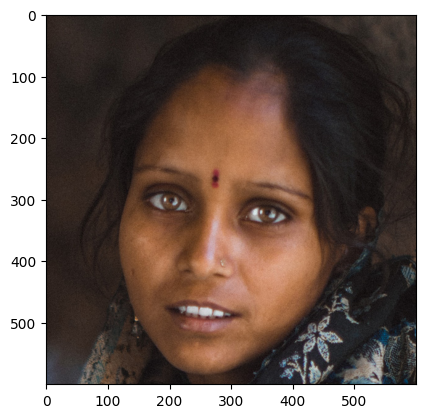

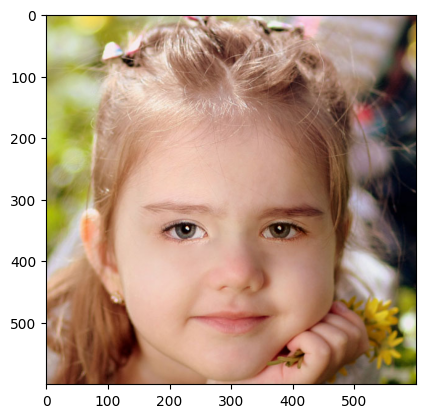

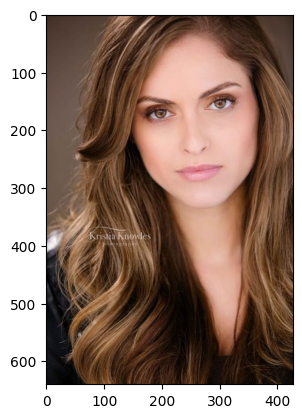

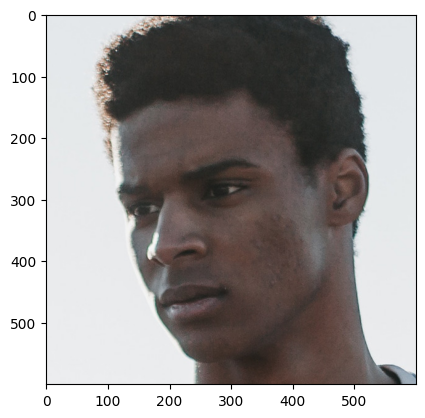

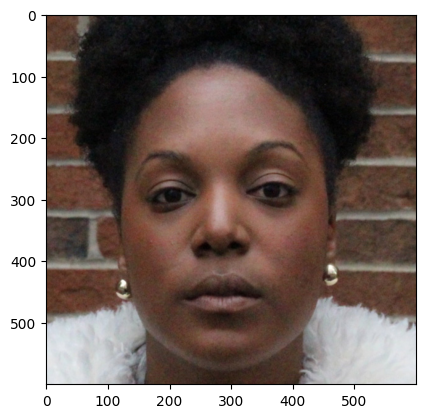

(array([], dtype=float64), array([], dtype=int64))


In [ ]:
# stats about the data files

# print(f"total of {len(os.listdir(data_path))} images")
# sizes = []

# im_transform = transforms.Compose([
#     transforms.Resize((512,512)),
#     transforms.ToTensor()
# ])

# c = 0
# human_images_paths = []
# for img in os.listdir(data_path):
#     image = Image.open(data_path + img)
#     im_tensor = im_transform(image)
#     if im_tensor.shape[0] != 3 and im_tensor.shape[0] != 4:
#         continue

#     # keep only RGB images
#     human_images_paths.append(data_path + img)
#     # print(human_images_paths[-1])

#     if c < 5:
#         plt.imshow(image)
#         plt.show()

#     c+= 1



# print(np.unique(sizes, return_counts=True))

# # save paths as pickle object
# with open('human_images_paths.pkl', 'wb') as f:
#     pickle.dump(human_images_paths, f)

## Build dataset class

### Original Data (without augmentation)

In [ ]:
class HumanFaceDataset(Dataset):
  def __init__(self, data_path = None, transform=None, images_paths_list = None):
    self.data_path = data_path # the folder that directly contains all the images
    self.transform = transform

    self.includes_path = images_paths_list is not None
    if images_paths_list:
      self.images = images_paths_list
    else:
      self.images = os.listdir(data_path)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.data_path + self.images[idx] if not self.includes_path else self.images[idx]
    print(img_path)
    image = Image.open(img_path)
    if self.transform:
      image = self.transform(image)

    if image.shape[0] == 4:
      image = image[:-1,:,:]
    # print(image.shape)
    # if image.shape[0] != 3:
    #   # print(self.data_path + self.images[idx])
    if image.dtype == torch.uint8:
      return image.float() / 255

    print(f"wierd image dtype found {img_path}, {image.dtype}")
    return image

### Augmentation Dataset

In [ ]:
class AugmentationHumanFaceDataset(Dataset):
  def __init__(self, data_path = None, transform=None, images_paths_list = None, augmentaions = []):
    """
    data_path: the folder that directly contains all the images
    transform: torchvision transform object that is applied to all images if not None
    images_paths_list: a list of filtered images paths,  if None then read all images in data_path
    augmentaions: a list of callables that are applied to all images, each augmentation is done separately on each image
    """
    self.data_path = data_path # the folder that directly contains all the images
    self.transform = transform

    self.includes_path = images_paths_list is not None
    self.augmentaions = augmentaions

    if images_paths_list:
      self.images = images_paths_list
    else:
      self.images = os.listdir(data_path)

  def __len__(self):
    return len(self.images) * len(self.augmentaions) # we produce  x versions of each  image (where x is len(self.augmentaions)

  def __getitem__(self, idx):
    """ remember we produce the augmented images in real time,
    for example: index 0 is image 0 with self.augmentation[0],
                 index 1 is image 0 with self.augmentation[1],
                 index 2 is image 0 with self.augmentation[2],
                 index 3 is image 1 with self.augmentation[0],
                 and so on ... indices depends on len(self.augmentaions)

    """
    folder_idx = idx // len(self.augmentaions)
    img_path = self.data_path + self.images[folder_idx] if not self.includes_path else self.images[folder_idx]
    image = Image.open(img_path)
    if self.transform:
      image = self.transform(image)


    if image.shape[0] == 4:
      image = image[:-1,:,:]

    if image.dtype == torch.uint8:
      image =  image.float() / 255
    else:
      print(f"\n\nwierd image dtype found {img_path}, {image.dtype}\n\n")

      if (image > 1).any():
        image = image / 255

    augmentation_idx = idx % len(self.augmentaions)
    aug_image = self.augmentaions[augmentation_idx](image)
    # print(image.shape)
    # if image.shape[0] != 3:
    #   # print(self.data_path + self.images[idx])
    return image

# Build CNN AE (bottleneck latent space)

In [ ]:
class BNconvEncoder(nn.Module): # BL = Bottle Neck
    def __init__(self, convs, act_fn = None):
        super(BNconvEncoder, self).__init__()
        act_fn = nn.LeakyReLU(0.2)
        # Define layers
        self.layers = nn.Sequential()
        for i in range(len(convs) - 1):
            self.layers.append(
                nn.Conv2d(convs[i], convs[i + 1], kernel_size=3, stride=1, padding=1))

            self.layers.append(nn.BatchNorm2d(convs[i + 1]))
            self.layers.append(act_fn)

            self.layers.append(
                nn.Conv2d(convs[i + 1], convs[i + 1], kernel_size=3, stride=2, padding=1))

            if i < len(convs) - 2:
              self.layers.append(nn.BatchNorm2d(convs[i + 1]))
              self.layers.append(act_fn)


    def forward(self, x):
        x = self.layers(x)
        return x


class BNconvDecoder(nn.Module): # BL = Bottle Neck
    def __init__(self, convs, act_fn = None):
        super(BNconvDecoder, self).__init__()
        act_fn = nn.LeakyReLU(0.2)
        self.layers = nn.Sequential()

        for i in range(len(convs)-1, 0, -1):
            # print(convs[i])

            self.layers.append(
                    nn.ConvTranspose2d(convs[i], convs[i - 1], kernel_size=3, padding=1))

            self.layers.append(act_fn)

            self.layers.append(
                    nn.ConvTranspose2d(convs[i - 1], convs[i - 1], kernel_size=3, stride=2, padding=1, output_padding=1))

            if i > 1:
              self.layers.append(act_fn)
              self.layers.append(nn.BatchNorm2d(convs[i - 1]))


    def forward(self, x):
        x = self.layers(x)
        return x

# Initialize the model
# model = convDecoder(convs)

# Print the model architecture
# print(model)

# class BNConvAE(nn.Module): # BL = Bottle Neck
#     def __init__(self, convs):
#         super(BNConvAE, self).__init__()
#         self.encoder = BNconvEncoder(convs)
#         self.decoder = BNconvDecoder(convs)

#     def forward(self, x):
#         # Flatten the input
#         latent = self.encoder(x)
#         x_recon = self.decoder(latent)

#         return x_recon


class BNConvAE(pl.LightningModule):
    def __init__(self, convs, loss_fn = nn.MSELoss()):
        super(BNConvAE, self).__init__()
        # Directly use your NN model as an attribute
        self.encoder = BNconvEncoder(convs)
        self.decoder = BNconvDecoder(convs)
        self.loss_fn = loss_fn

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

    def training_step(self, batch, batch_idx):
        data = batch.to(self.device).float()
        x_recon = self(data)
        loss = self.loss_fn(x_recon, data)

        # Log training loss
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)


# Initialize the model
convs = [3, 8, 16, 20,24,32]
model = BNConvAE(convs)
print(model)

BNConvAE(
  (encoder): BNconvEncoder(
    (layers): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2)
      (12): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(20,

## Train Model

In [ ]:
# data_path = './1/Humans/'


human_image_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.PILToTensor()])


convs = [3, 8, 16, 20]
convs = {
    "exp1": [3, 8, 16, 20,24,32],
    "exp2": [3, 16, 24,32, 64, 64]
}
model = BNConvAE(convs["exp1"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

augmentations = [
    lambda tensor: tensor,
    lambda tensor: tensor + torch.randn_like(tensor) * 0.04,
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
]

# train_dataset = HumanFaceDataset(data_path, transform=human_image_transform, images_paths_list=human_images_paths[:100])
train_dataset = AugmentationHumanFaceDataset(data_path, transform=human_image_transform, images_paths_list=human_images_paths, augmentaions=augmentations)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)


# trainer = pl.Trainer(max_epochs=9, devices='auto', precision='16-mixed', accelerator="gpu" if torch.cuda.is_available() else "cpu")
trainer = pl.Trainer(max_epochs=9, devices='auto', precision='16-mixed', accelerator="gpu" if torch.cuda.is_available() else "cpu")

trainer.fit(model, train_dataloaders=train_loader)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:513: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | encoder | BNconvEncoder | 36.9 K | train
1 | decoder | BNconvDecoder | 27.5 K | train
2 | loss_fn | MSELoss       | 0      | train
--------------------------------------------------
64.4 K    Trainable params
0         Non-trainable params
64.4 K    Total params
0.258  

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=9` reached.


In [ ]:
augmentations = [
    lambda tensor: tensor,
    lambda tensor: tensor + torch.randn_like(tensor) * 0.05,
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
]

train_dataset = AugmentationHumanFaceDataset(data_path, transform=human_image_transform, images_paths_list=human_images_paths, augmentaions=augmentations)
# train_dataset = HumanFaceDataset(data_path, transform=human_image_transform, images_paths_list=human_images_paths[:100])
human_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.PILToTensor()])

sample = train_dataset[10]
sample.shape
# im = Image.open("./1/Humans/1 (6784).jpg")
# plt.imshow(sample.cpu().numpy().transpose(1, 2, 0))
# # plt.imshow(human_image_transform(im).cpu().float().numpy().transpose(1, 2, 0) / 255)
# plt.show()
# human_image_transform(im).cpu().shape

# a = human_image_transform(im).cpu().float()
# b = human_image_transform(im).cpu()

# b.dtype == torch.uint8

model.encoder(sample.unsqueeze(dim = 0)).shape

torch.Size([1, 32, 2, 2])

In [ ]:
from google.colab import files

model_save_path = "human_V3.pth"

# Save the model's state_dict
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

files.download(model_save_path)


Model saved to human_V3.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Some results examination


In [ ]:
def reconstruct_image(model, im_path = "./1/Humans/1 (96).png", input_image_size=(64,64)):
    # im_path = "./1/Humans/1 (96).png"
    # im_path = '/content/1/Humans/1 (1684).jpg'

    image = Image.open(im_path)
    print(transforms.ToTensor()(image).shape)
    plt.imshow(image)
    plt.title("Original")
    plt.show()

    transform = transforms.Compose([
        transforms.Resize(input_image_size),
        transforms.ToTensor()
    ])

    image = transform(image)
    if image.shape[0] == 4:
        image = image[:-1,:,:]

    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.title("input")
    plt.show()

    image = image.unsqueeze(0)
    # print(image)
    model.eval()
    with torch.no_grad():
      model.to(device)
      dec = model(image.to(device).float())

    plt.imshow(dec.detach().squeeze().cpu().numpy().transpose(1, 2, 0))
    plt.title("model reconstruction")
    plt.show()

## big image model

### Without noise

torch.Size([4, 1200, 1143])


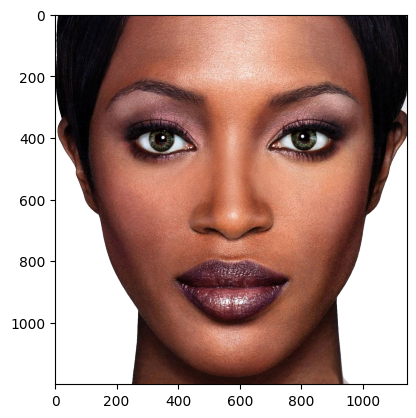

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.4980, 0.9412, 0.9098],
          [0.0000, 0.0000, 0.0000,  ..., 0.3020, 0.8824, 0.9373],
          [0.0000, 0.0000, 0.0000,  ..., 0.1843, 0.8039, 0.9412],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4824, 0.9333, 0.9059],
          [0.0000, 0.0000, 0.0000,  ..., 0.2863, 0.8706, 0.9333],
          [0.0000, 0.0000, 0.0000,  ..., 0.1686, 0.7961, 0.9333],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.5412, 0.9451, 0.8745],
          [0.0000, 0.0000, 0.0000,  ..., 0.3451, 0.8902, 0.9098],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
reconstruct_image(model)


### With noise

torch.Size([4, 1200, 1143])


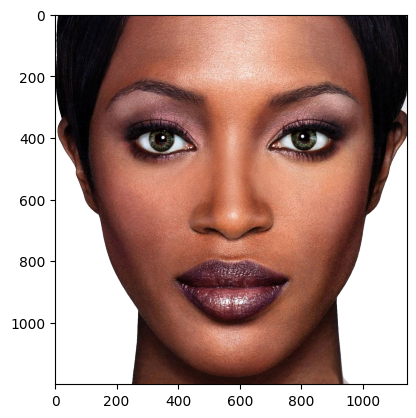

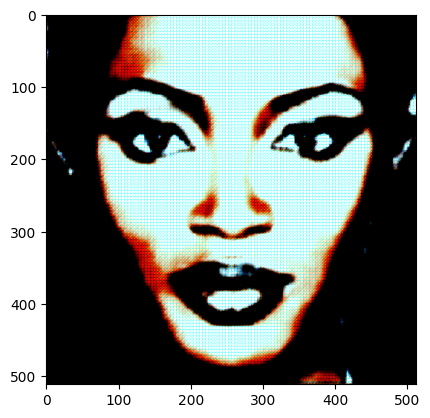

In [ ]:
reconstruct_image(model)

## Small latent spatial size (human_V2), 10 epochs

torch.Size([4, 1200, 1143])


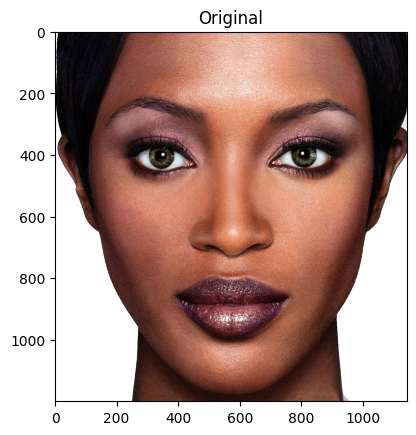

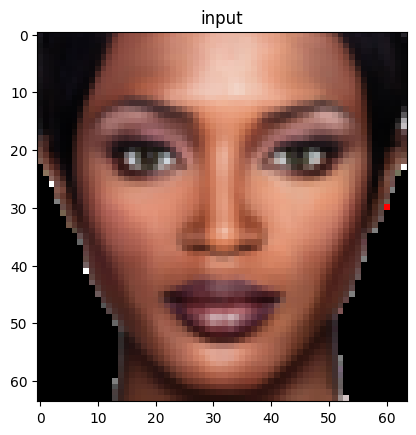

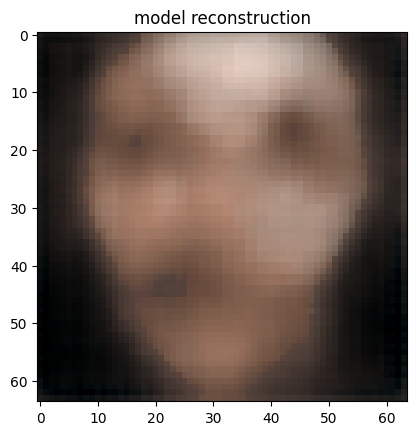

In [ ]:
# model.to("cpu")
reconstruct_image(model)

In [ ]:
64x2x2

torch.Size([3, 4752, 3168])


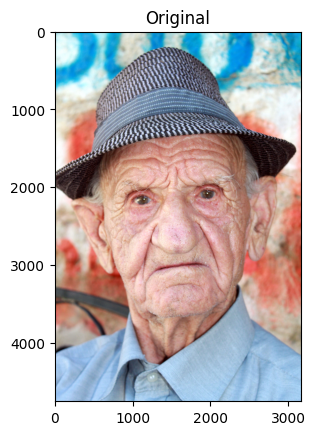

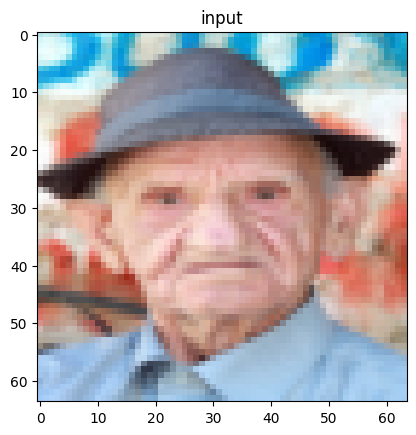

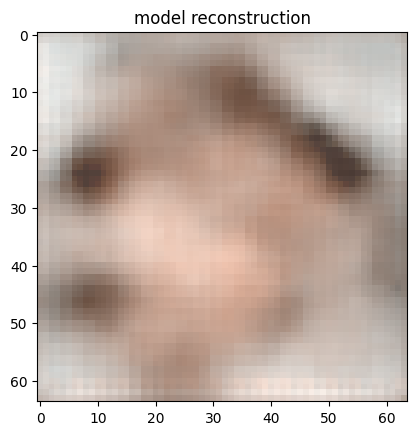

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1015).jpg") # trained on the whole data

torch.Size([3, 547, 602])


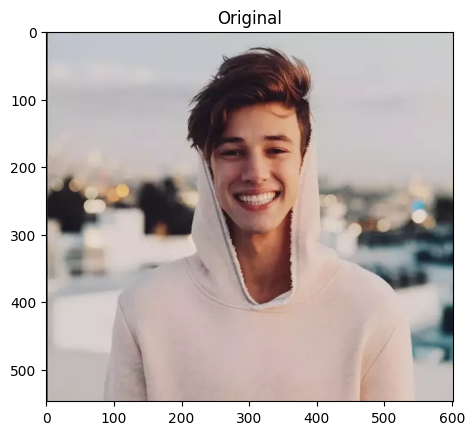

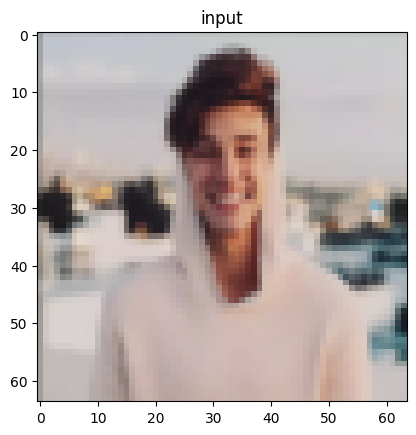

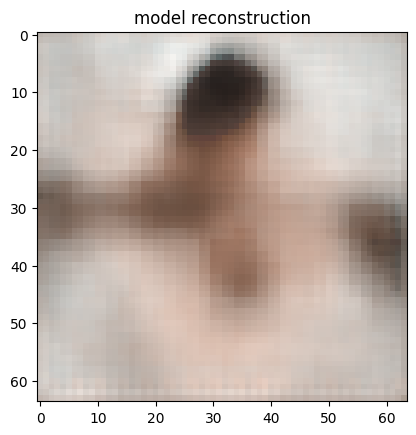

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1064).jpg")

## Small latent spatial size (human_V3), 9 epochs

torch.Size([4, 1200, 1143])


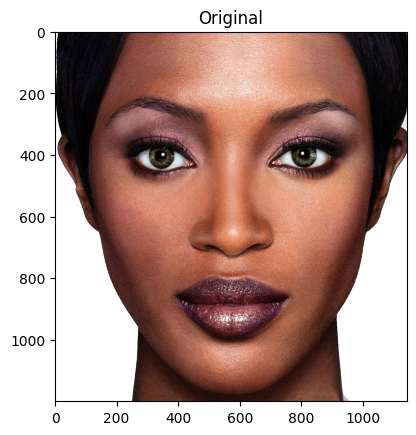

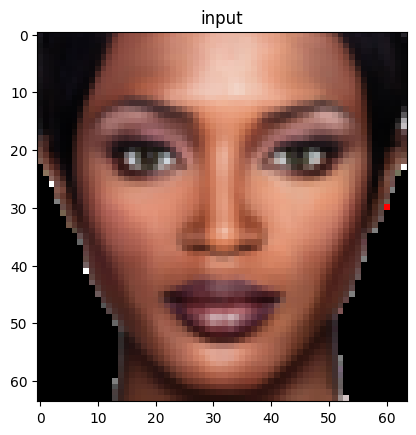

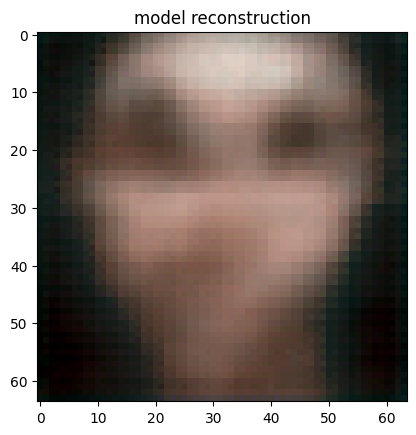

In [ ]:
reconstruct_image(model)

torch.Size([3, 4752, 3168])


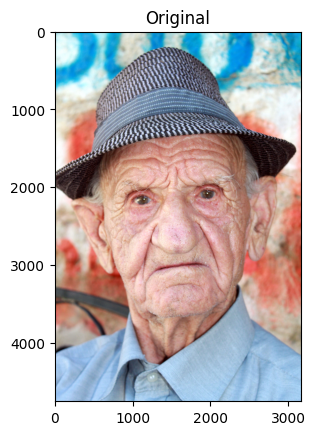

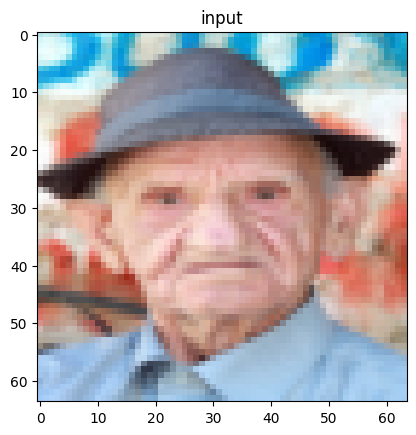

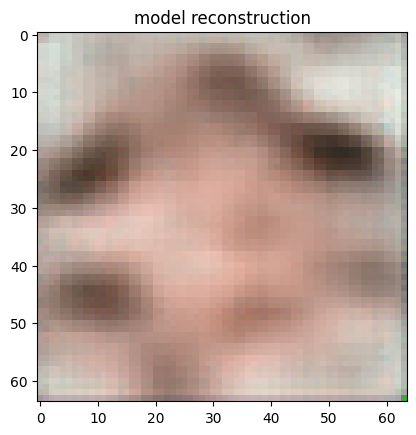

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1015).jpg") # trained on the whole data

torch.Size([3, 547, 602])


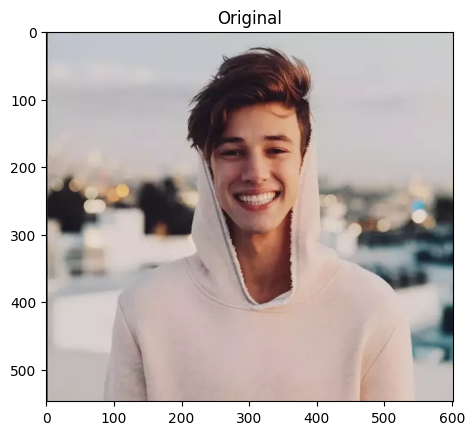

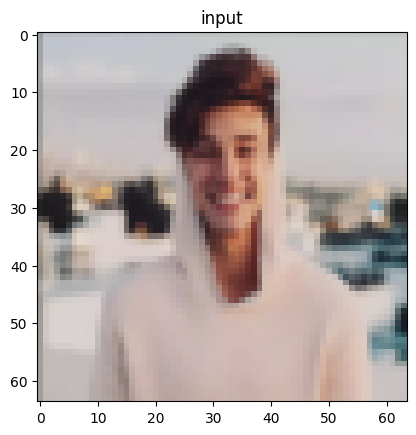

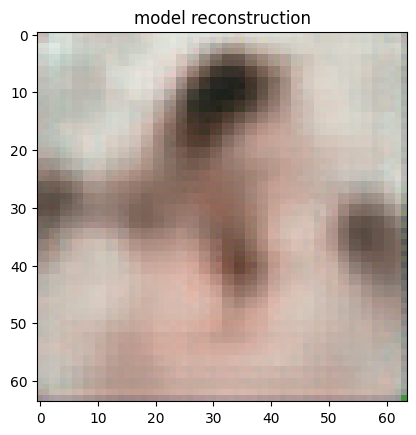

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1064).jpg")

## multi augmnetations

### 10 epochs

torch.Size([4, 1200, 1143])


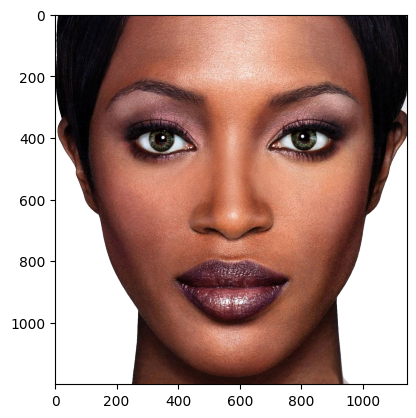

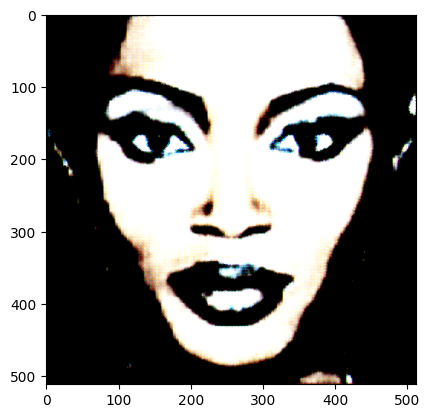

In [ ]:
reconstruct_image(model)

torch.Size([3, 4752, 3168])


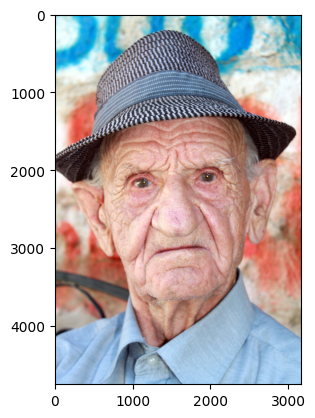

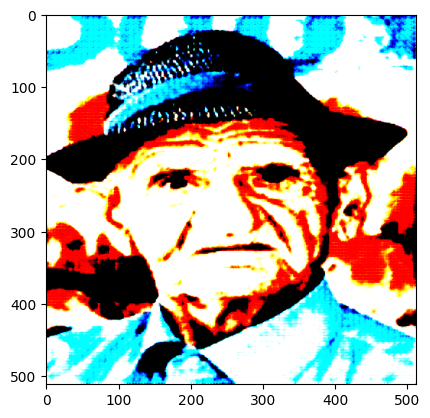

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1015).jpg") # trained on the whole data

### 6 epochs all data

torch.Size([3, 4752, 3168])


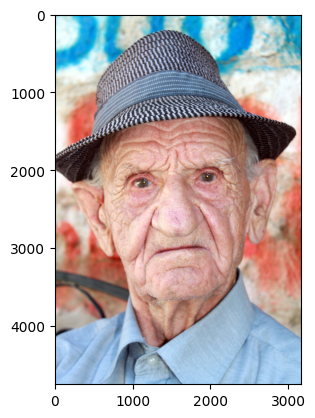

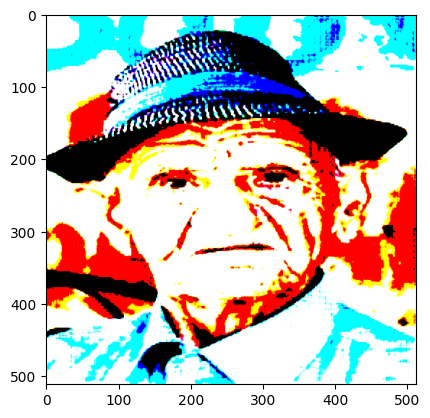

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1015).jpg") # trained on the whole data

### 20 epochs

torch.Size([3, 4752, 3168])


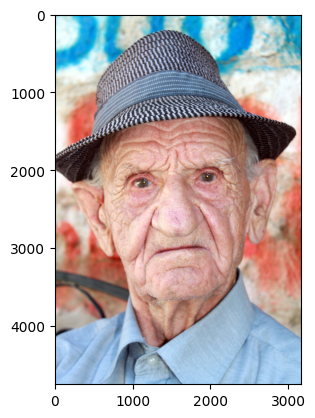

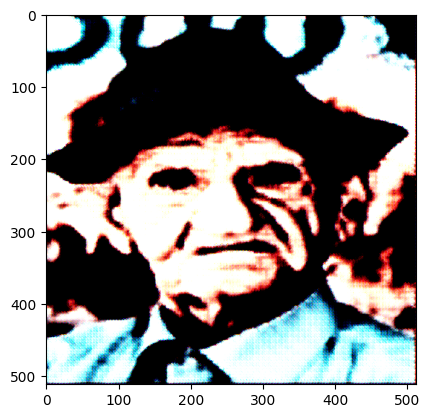

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1015).jpg")

torch.Size([3, 547, 602])


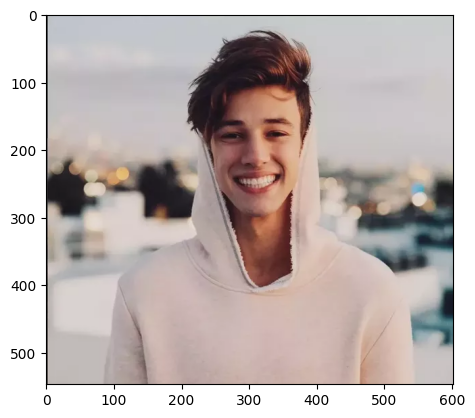

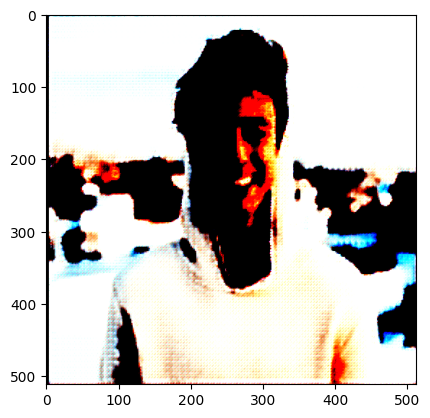

In [ ]:
reconstruct_image(model, "/content/1/Humans/1 (1064).jpg")

In [ ]:
def tensize(tensor):
    num_elements = tensor.numel()  # Total number of elements in the tensor
    element_size = tensor.element_size()  # Size of each element in bytes
    memory_bytes = num_elements * element_size
    return memory_bytes / (1024 ** 2)

tensize(recon_batch), tensize(data)

(48.0, 12.0)

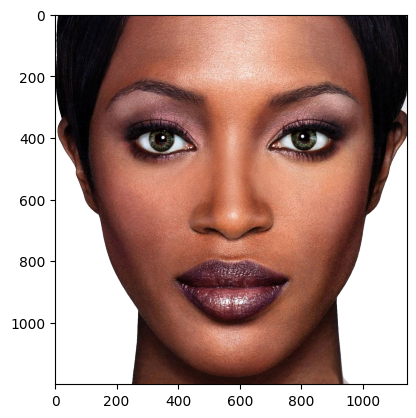

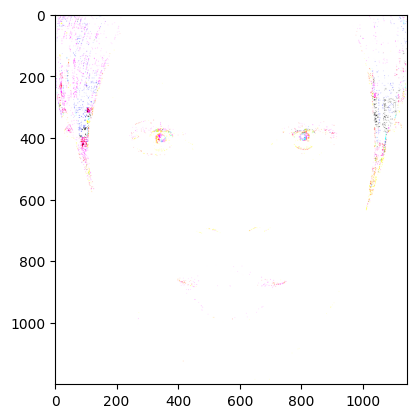

(1200, 1143, 4)

In [ ]:
# show image
im_path = "./1/Humans/1 (96).png"
# im_path = "/content/1/Humans/1 (1).png"
image = Image.open(im_path)

# add gaussian noise to the image
image = np.array(image)
noise = np.random.normal(0, 0.01, image.shape)
noisy_image = image + noise

plt.imshow(image)
plt.show()

plt.imshow(noisy_image[:,:,:])
plt.show()
noisy_image.shape

# Using pretrained models